## 畳み込み層

画像には局所性（隣接するピクセルの影響を受ける事）があるので、それを利用して画像の特徴を強調したりできる。  
やってることはフィルタを用意して、画像に畳み込み計算を行う事。

以下の例みたいに、左上からフィルタを適用して 1 セル生成。したら、右に 1 セルずらして…と繰り返す。

$$
\left[
    \begin{array}{cc}
        1 & 0 \\
        0 & 1 \\
    \end{array}
\right]
\times
\left[
    \begin{array}{cccc}
        2 & 2 & 1 & 2 \\
        1 & 1 & 2 & 1 \\
        1 & 2 & 1 & 0 \\
        1 & 0 & 0 & 1 \\
    \end{array}
\right]
\longrightarrow
\left[
    \begin{array}{ccc}
        3 & 4 & 2 \\
        3 & 2 & 2 \\
        1 & 2 & 2 \\
    \end{array}
\right]
$$

見ての通り画像自体は小さくなる。

因みにこのずらす間隔をストライドと呼ぶ。  
ストライド幅が大きいほど画像サイズは小さくなり、特徴が見逃されやすくなる。


## プーリング層

畳み込み層の直後に配置する。  
画像を領域単位で区切り、領域の代表値を取得します。

例えば 2x2 の MAX スプーリングであれば、2x2 の単位で画像を区切って最大値を取得するので

$$
\left[
    \begin{array}{cccc}
        2 & 2 & 1 & 2 \\
        1 & 1 & 2 & 1 \\
        1 & 2 & 1 & 0 \\
        1 & 0 & 0 & 1 \\
    \end{array}
\right]
\longrightarrow
\left[
    \begin{array}{cc}
        2 & 2 \\
        2 & 1 \\
    \end{array}
\right]
$$

みたいにできる。  
見ての通り学習もクソもない

## 全結合

全結合層は、畳み込み層とプーリング層を複数挟んだ後に用意される。  
要するに普通のニューロン

食わせるときにはフラットなベクトルにして食わせる。

## パディング

上記処理してると画像サイズが処理に合わない場合があるので、画像が元のサイズを保てるように周囲に 0 の空データの枠を作る。


# 変数の一覧

|変数名 |解説 |
|---   |--- |
| $B$ | バッチサイズ |
| $C$ | チャンネル数 |
| $I_h$ | 入力画像の高さ |
| $I_w$ | 入力画像の幅 |
| $M$ | フィルタ数 |
| $F_h$ | フィルタの高さ |
| $F_w$ | フィルタ幅 |
| $O_h$ | 出力画像の高さ |
| $O_w$ | 出力画像の幅 |
| $P$ | プーリング領域サイズ |


※ チャンネル = RGB 等のデータの軸



## im2col

画像に対して畳み込みを行うには形状がめんどくさいので以下みたいに配置しなおす。  
これを im2col と呼ぶっぽい。

$$
\left[
    \begin{array}{cc}
        2 & 2 \\
        1 & 1 \\
    \end{array}
\right]
\longrightarrow
\left[
    \begin{array}{c}
        2 \\
        2 \\
        1 \\
        1 \\
    \end{array}
\right]
$$

例えば 2x2 のフィルタで 3x2 のデータに適用するとき、まずは im2col でこんな風にしてしまう

$$
\left[
    \begin{array}{ccc}
        2 & 2 & 3 \\
        1 & 1 & 2 \\
    \end{array}
\right]
\longrightarrow
\left[
    \begin{array}{cc}
        2 & 2 \\
        2 & 3 \\
        1 & 1 \\
        1 & 2 \\
    \end{array}
\right]
$$

すると フィルタを $ [ 1, 2, 3, 4 ] $ の様に定義すればドット積1回で計算できる。  
バッチとチャンネルを無視して考えれば、基本は

* 高さ =  $F_h F_w$
* 幅 = $O_h O_w$

のサイズになる。

実際にはチャンネルごとにフィルタはあるので高さに加算。バッチサイズが幅に加算される。

* 高さ = $C F_h F_w$
* 幅 = $B O_h O_w$


In [1]:
import numpy as np

def im2col(image, flt_h, flt_w, out_h, out_w):
    img_h, img_w = image.shape
    cols = np.zeros((flt_h, flt_w, out_h, out_w))
    for h in range(flt_h):
        h_lim = h + out_h
        for w in range(flt_w):
            w_lim = w + out_w
            cols[h, w, :, :] = image[h:h_lim, w:w_lim]
    cols = cols.reshape(flt_h*flt_w, out_h*out_w)
    return cols

In [2]:
img = np.array([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9,10,11,12],
    [13,14,15,16]
])

cols = im2col(img, 2, 2, 3, 3)
cols

array([[ 1.,  2.,  3.,  5.,  6.,  7.,  9., 10., 11.],
       [ 2.,  3.,  4.,  6.,  7.,  8., 10., 11., 12.],
       [ 5.,  6.,  7.,  9., 10., 11., 13., 14., 15.],
       [ 6.,  7.,  8., 10., 11., 12., 14., 15., 16.]])

画像は [こちら](https://blog.goo.ne.jp/bluecat-007/e/bcc6ce3356d57bea9bd1c731ae64dfd9) のを使わせていただいた

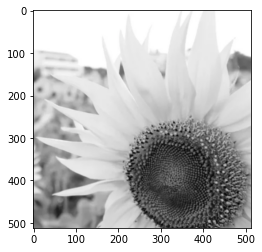

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 読み込んで表示しただけ
img = plt.imread('himawari.png')
plt.imshow(img)
plt.show()

In [4]:
np.array(img).shape

(512, 512, 3)

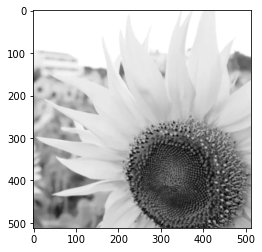

In [5]:
import statistics
# カラー情報を捨ててモノクロに
arr_monochro = [[statistics.mean(cell) for cell in y] for y in img]
plt.imshow(arr_monochro, 'gray', vmin = 0, vmax = 1)
plt.show()

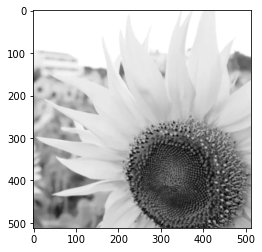

In [6]:
changed = np.array(arr_monochro)
changed

plt.imshow(changed, 'gray', vmin = 0, vmax = 1)
plt.show()

In [7]:
changed.shape

(512, 512)

In [8]:
cols = im2col(changed, 3, 3, 510, 510)
cols.shape

(9, 260100)

In [9]:
def col2im(cols, img_shape, flt_h, flt_w, out_h, out_w):
    img_h, img_w = img_shape
    cols = cols.reshape(flt_h, flt_w, out_h, out_w).transpose(0, 1, 2, 3)
    images = np.zeros((img_h, img_w))
    for h in range(flt_h):
        h_lim = h + out_h
        for w in range(flt_w):
            w_lim = w + out_w
            images[h:h_lim, w:w_lim] += cols[h, w]
    return images / (flt_h * flt_w)

In [10]:
rev_img = col2im(cols, (512, 512), 3, 3, 510, 510)

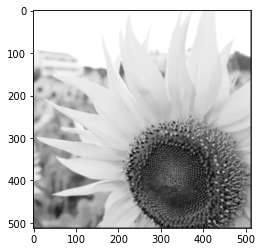

In [11]:
plt.imshow(rev_img, 'gray', vmin = 0, vmax = 1)
plt.show()

チャンネルとかパディング(padding : 画像の外枠に入れる 0 の領域)、ストライド(stride : フィルタを適用するズレ)などを色々真面目に実装

In [12]:
def im2col(images, flt_h, flt_w, out_h, out_w, stride, pad):
    n_bt, n_ch, img_h, img_w = images.shape
    img_pad = np.pad(images, [(0,0), (0,0), (pad, pad), (pad, pad)], "constant")
    cols = np.zeros((n_bt, n_ch, flt_h, flt_w, out_h, out_w))
    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            cols[:, :, h, w, :, :] = img_pad[:, :, h:h_lim:stride, w:w_lim:stride]
    cols = cols.transpose(1, 2, 3, 0, 4, 5).reshape(n_ch*flt_h*flt_w, n_bt*out_h*out_w)
    return cols

def col2im(cols, img_shape, flt_h, flt_w, out_h, out_w, stride, pad):
    n_bt, n_ch, img_h, img_w = img_shape
    cols = cols.reshape(n_ch, flt_h, flt_w, n_bt, out_h, out_w, ).transpose(3, 0, 1, 2, 4, 5)
    images = np.zeros((n_bt, n_ch, img_h+2*pad+stride-1, img_w+2*pad+stride-1))
    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            images[:, :, h:h_lim:stride, w:w_lim:stride] += cols[:, :, h, w, :, :]
    return images[:, :, pad:img_h+pad, pad:img_w+pad]

# img2col
img = np.array([[[[1, 2, 3, 4],
                  [5, 6, 7, 8],
                  [9, 10,11,12],
                  [13,14,15,16]]]])
print(img.shape)
cols = im2col(images=img, flt_h=2, flt_w=2, out_h=3, out_w=3, stride=1, pad=0)
print(cols)

# col2img
cols = np.ones((4, 4))
img_shape = (1, 1, 3, 3)
images = col2im(cols=cols, img_shape=img_shape, flt_h=2, flt_w=2, out_h=2, out_w=2, stride=1, pad=0)
print(images)

(1, 1, 4, 4)
[[ 1.  2.  3.  5.  6.  7.  9. 10. 11.]
 [ 2.  3.  4.  6.  7.  8. 10. 11. 12.]
 [ 5.  6.  7.  9. 10. 11. 13. 14. 15.]
 [ 6.  7.  8. 10. 11. 12. 14. 15. 16.]]
[[[[1. 2. 1.]
   [2. 4. 2.]
   [1. 2. 1.]]]]


In [13]:
img = plt.imread('himawari.png')
img = np.array([img]).transpose(0, 3, 1, 2)
img.shape

(1, 3, 512, 512)

バッチサイズ 1, RGB 3チャンネル, 512 x 512 Pixel

In [14]:
cols = im2col(images=img, flt_h=3, flt_w=3, out_h=510, out_w=510, stride=1, pad=0)
print(cols)

[[1.         1.         1.         ... 0.70588237 0.70588237 0.70980394]
 [1.         1.         1.         ... 0.70588237 0.70980394 0.71372551]
 [1.         1.         1.         ... 0.70980394 0.71372551 0.71372551]
 ...
 [1.         1.         1.         ... 0.71764708 0.71372551 0.71372551]
 [1.         1.         1.         ... 0.71372551 0.71372551 0.71372551]
 [1.         1.         1.         ... 0.71372551 0.71372551 0.71764708]]


In [15]:
cols.shape

(27, 260100)

In [16]:
img_shape = (1, 3, 512, 512)
images = col2im(cols=cols, img_shape=img_shape, flt_h=3, flt_w=3, out_h=510,  out_w=510, stride=1, pad=0)
images.shape

(1, 3, 512, 512)

In [17]:
images = images[0].transpose(1, 2, 0)
images.shape

(512, 512, 3)

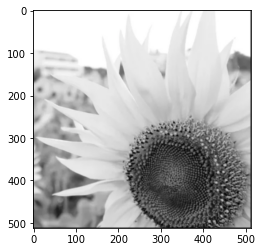

In [18]:
plt.imshow(images / 9)
plt.show()